In [23]:
import sys
sys.path.append('..')
from bast.tools import incident, compute_currents, nanometers, compute_fluxes
from bast.matrices import matrix_s, multS
from bast.tools import c
from bast.lattice import CartesianLattice
import numpy as np
from math import prod

pw=(3, 3)
a  = nanometers(175)
lattice = CartesianLattice(pw, a1=(a, 0.0), a2=(0.0, a), eps_emerg=2.43)
freq = np.linspace(0.22, 0.5, 200) * c / a
#freq = np.linspace(0.545, 0.554, 50) * c / a
wavelengths = c / freq
r = 0.4 * a
d = 0.55 * a
eps1 = 5.0
eps0 = 1.0

In [28]:
from bast.scattering import scattering_matrix, scattering_interface, scattering_air_tmp
from tqdm import tqdm

spectrum = []
pin = incident(pw)
for i, wavelength in enumerate(tqdm(wavelengths)):
    
    # S-matrices 
    S_interface = scattering_interface(lattice, wavelength, kp=(0,0))
    #S_cyl = scattering_matrix(pw, lattice, "disc", [0.0*a, 0.0*a, r], island_eps=eps0, eps_host=eps1, wavelength=wavelength, depth=d, kp=(0,0))
    S1 = scattering_matrix(pw, lattice, "rectangle", [0, 0, 0.514*a, 1.0*a], 2.43, 1.0, kp=(0,0), wavelength=wavelength, depth=0.8*a, slicing_pow=4)
    S2 = scattering_matrix(pw, lattice, "uniform", [], 2.43, 2.43, kp=(0,0), wavelength=wavelength, depth=0.2*a, slicing_pow=4)
    S = S1 @ S2
    for i in range(4):
        S = S @ S
    #S_int, _ = scattering_matrix(pw, lattice, "uniform", [], island_eps=eps0, eps_host=eps0, wavelength=wavelength, depth=0.1*a, kp=(0,0))
    #S_int = scattering_air_tmp(pw, lattice, wavelength=wavelength, depth=0.1*a)
    #S = multS(S_cyl, S_int) # S_cyl @ S_int
    #S = multS(S, S_cyl)
    S = S @ S_interface

    # Spectrum
    pout = S @ pin
    R_tot, T_tot, A_tot = compute_fluxes(lattice, wavelength, pin, pout)

    spectrum.append((R_tot,T_tot))

 10%|▉         | 19/200 [00:25<03:59,  1.32s/it]


KeyboardInterrupt: 

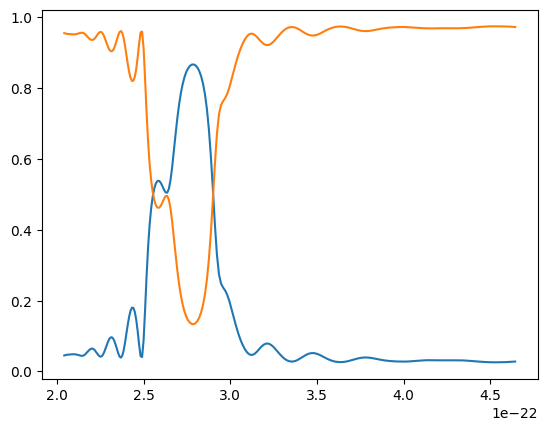

In [27]:
import matplotlib.pyplot as plt
s = np.asarray(spectrum).T
plt.plot(a/ freq, s[0], label="R")
plt.plot(a/freq, s[1], label="T")
plt.savefig("holes.png")
#np.savetxt("rcwa_9x9_0s_100p.txt", np.vstack((freq/c*a, s)).T)
np.savetxt("rcwa_5x5_holes_100p.txt", np.vstack((freq/c*a, s)).T)


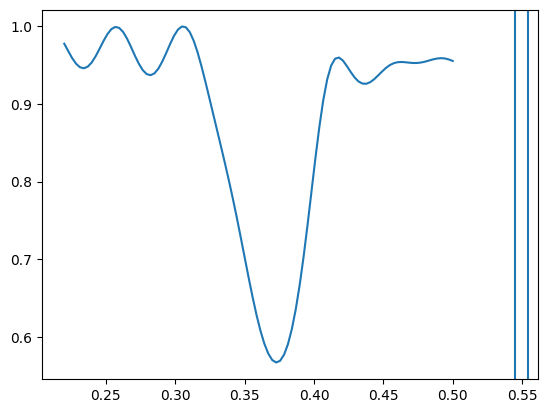

In [18]:
# Zoom
import matplotlib.pyplot as plt
s = np.asarray(spectrum).T
#plt.plot(freq /c *a, s[0], label="R")
plt.plot(freq /c *a, s[1], label="T")
plt.axvline(0.545)
plt.axvline(0.554)
plt.savefig("fan2003.png")

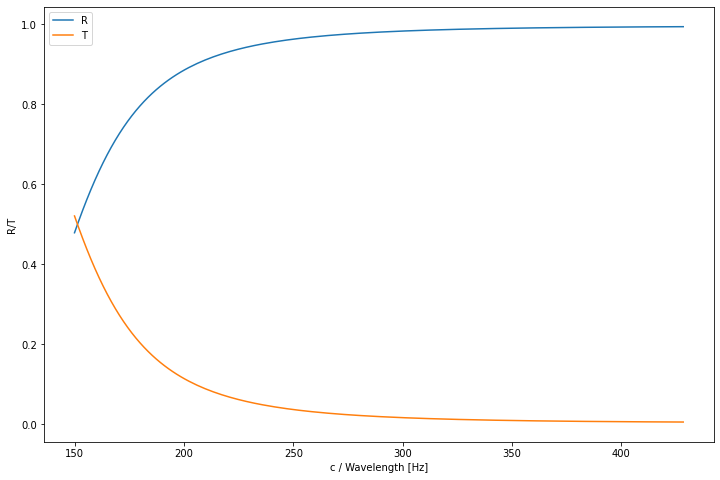

In [119]:
import matplotlib.pyplot as plt
from bast.tools import c
fig, ax = plt.subplots(figsize=(12,8))
ax.plot(c / wavelengths/1e12, spectrum, label=["R", "T"])
ax.set_xlabel("c / Wavelength [Hz]")
ax.set_ylabel("R/T")
#plt.axis([0, 1, 0, 1.2])
plt.legend()

In [120]:
from tqdm import tqdm
from bast.eigentricks import scattering_eigenvalues, on_shell
eigenspace = {  wavelength: scattering_eigenvalues(S, dos=True)  for wavelength, S in zip(wavelengths, tqdm(scatmats)) }
eigenspace = dict(filter(lambda x: x[1] is not None, eigenspace.items()))


  0%|                                                                                                                                                                  | 0/150 [00:00<?, ?it/s]/home/kaeryv/prj/minerva/env/lib/python3.10/site-packages/numpy/linalg/linalg.py:2146: RuntimeWarning: overflow encountered in det
  r = _umath_linalg.det(a, signature=signature)
/home/kaeryv/prj/bast/notebooks/../bast/eigentricks.py:28: RuntimeWarning: invalid value encountered in cdouble_scalars
  return np.linalg.det(S[p,p] + S[p,m] @ np.linalg.inv(S[m,m]) @ S[m,p]) * np.linalg.det(S[m,m])
 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 149/150 [00:41<00:00,  3.63it/s]


In [115]:

for i, (w, v, dos) in enumerate(eigenspace.values()):
    is_on_shell = on_shell(w, tol=1e-3)
    w[np.logical_not(is_on_shell)] = np.nan
    v[:, np.logical_not(is_on_shell)] = np.nan


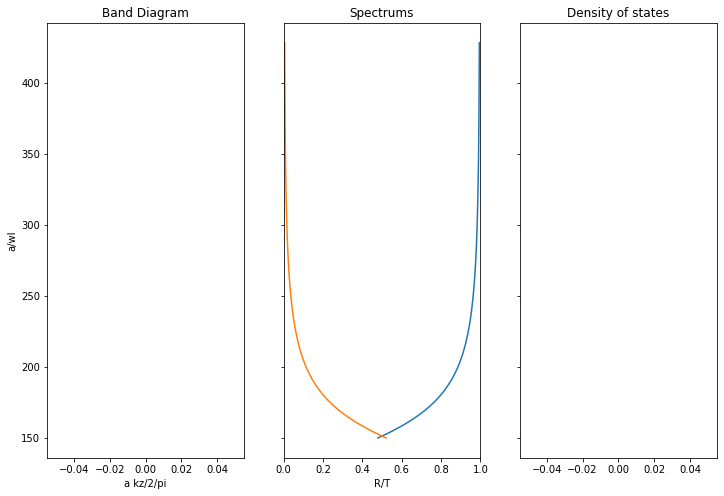

In [116]:
import matplotlib.pyplot as plt
from scipy.constants import c
fig, axs = plt.subplots(1,3, figsize=(12,8), sharey=True)
eig_w = np.asarray([ w for w, v, dos in eigenspace.values() ])
eig_wl = np.asarray([ wl*np.ones(len(w)) for wl, (w, v, dos) in eigenspace.items() ])
eig_dos = np.asarray([ dos for wl, (w, v, dos) in eigenspace.items() ])
eig_v = np.asarray([ v for wl, (w, v, dos) in eigenspace.items() ])
axs[0].scatter(np.angle(eig_w) / np.pi / 2, c / eig_wl / 1e12, s=2)
#axs[0].scatter(np.angle(eig_w[eig_w.imag < 0]) / np.pi / 2, c / eig_wl[eig_w.imag<0], s=25, c='r', alpha=0.2)
axs[2].plot(np.abs(np.diff(np.log(eig_dos))/2j/np.pi), c / wavelengths[:-1]/ 1e12)
axs[2].set_title("Density of states")
axs[1].set_title("Spectrums")
axs[0].set_title("Band Diagram")
axs[1].set_xlim(0, 1)
#axs[0].set_ylim(0.0, 1e-2)
axs[1].plot(np.asarray(spectrum)[:,0], c / wavelengths/ 1e12)
axs[1].plot(np.asarray(spectrum)[:,1], c / wavelengths/ 1e12)
#axs[1].set_ylim(0.0, 1.0)
axs[1].set_xlabel("R/T")
axs[0].set_xlabel("a kz/2/pi")
axs[0].set_ylabel("a/wl")
#heur = np.loadtxt("../data/values.txt").reshape(100, 5)
#for i in range(5):
#    axs[0].plot(heur[:, i]/2/np.pi, a / wavelengths, 'r.');
plt.savefig("Band-Diagram.png")

In [98]:
wl = 0
wavelength = wavelengths[wl]
Vi = lattice.Vi(wavelength, theta, phi)
#mask = on_shell(eig_w[wl], tol=1e+10)
#VV = eig_w[wl][mask]
#P = eig_v[wl][:, mask]
#PP = P
PP = the_vec
print(PP.shape, Vi.shape)
resolution =(300,300)

num_modes = min(PP.shape[1], 6)
fig, axs = plt.subplots(1, num_modes, figsize=(24,12))
kx, ky = lattice.kp(wavelength, theta, phi)
from itertools import product
from numpy import matlib as ml
from bast.tools import mu0, c
ng = pw[0]*pw[1]
for i in range(num_modes):
    P = PP[:,i]
    P = Vi @ P
    Exg, Eyg, Hxg, Hyg = np.split(P, 4)
    ng = Exg.shape[0]
    mulx = 1
    muly = 1
    vx = np.linspace(-mulx*a, muly*a, resolution[0])
    vy = np.linspace(-mulx*a, muly*a, resolution[1])
    ux = kx + lattice.gx.T.flatten()
    uy = ky + lattice.gy.T.flatten()
    xy = np.asarray(list(product(vx, vy))).reshape(*resolution, 2)
    uxy_x = np.outer(ux, xy[:,:,0]).reshape(ng, *resolution)
    uxy_y = np.outer(uy, xy[:,:,1]).reshape(ng, *resolution)
    fxy = np.exp(1j*(uxy_x+uxy_y))
    Ex = np.sum(Exg.reshape(ng, 1, 1) * fxy, axis=0)
    Ey = np.sum(Eyg.reshape(ng, 1, 1) * fxy, axis=0)
    Hx = np.sum(Hxg.reshape(ng, 1, 1) * fxy, axis=0)
    Hy = np.sum(Hyg.reshape(ng, 1, 1) * fxy, axis=0)
    #axs[i].set_title(f"{round(VVV.real, 3), round(VVV.imag, 3)}")
    axs[i].matshow(ml.repmat((np.real(Ey)).reshape(resolution), 1, 1), cmap="RdBu")
    #axs[i].matshow(np.load("im1.npy"), alpha=0.5)
plt.savefig("Eigenmodes.png")


NameError: name 'the_vec' is not defined

In [ ]:
fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(24,12))
ax1.matshow(ml.repmat(np.load("im1.npy"), 2, 2), extent=[-1,1, -1, 1],alpha=0.5)
ax1.matshow(ml.repmat(np.load("im2.npy"), 2, 2), extent=[-1,1, -1, 1], alpha=0.5)
ax2.matshow(ml.repmat((np.abs(Ey*Hx+Ey*Hy)).reshape(resolution), 1, 1), extent=[-1,1, -1, 1], cmap="RdBu", alpha=0.9)


In [ ]:
from bast.fourier import transform_disc, transform_rectangle
import matplotlib.pyplot as plt
aa = transform_disc(0.5*a,0.5*a, 0.2*a, lattice.Gx, lattice.Gy, lattice.area)
bb = transform_rectangle(0.5*a,0.0*a, a, a, lattice.Gx, lattice.Gy, lattice.area)

plt.matshow(np.abs(aa))
plt.matshow(np.abs(np.fft.ifft2(bb)))
print(np.max(np.abs(np.fft.ifft2(bb))) *  12 * 12)

In [ ]:
bb = transform_disc(0.5*a,0.5*a, 0.3*a, lattice.Gx, lattice.Gy, lattice.area)
from math import prod
plt.matshow(np.abs(np.fft.ifft2(bb)))
np.max(np.real(np.fft.ifft2(bb)))*prod(bb.shape)


In [ ]:
bb

In [ ]:
plt.pcolor(np.abs(lattice.Gy))
np.abs(lattice.Gy).max()

In [ ]:
a = np.random.rand(10, 20, 30)
b = np.linspace(0, 3, 20) < 1.5
a[:, b, :].shape 
a = 1e-7

In [ ]:
real = np.ones((12,12))
fft = np.fft.fftshift(np.fft.fft2(real))  / 12 / 12
fft2 = transform_rectangle(0.0*a,0.0*a, a, a, lattice.Gx, lattice.Gy, lattice.area)
plt.matshow(np.abs(fft))
plt.matshow(np.abs(fft2))
print(fft)
print(fft2)